# <center>Audio Emotion Recognition</center>
## <center>Part 4 - Apply to new audio data</center>
#### <center> 31st August 2019 </center> 
#####  <center> Eu Jin Lok </center> 

In [58]:
# Importing required libraries 
from keras.models import Sequential, Model, model_from_json
import matplotlib.pyplot as plt
import keras 
import pickle
import wave  # !pip install wave
import os
import pandas as pd
import numpy as np
import sys
import warnings
import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [124]:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 
CHANNELS = 2 
RATE = 44100 
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "test_audio\\testing.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()


* recording
* done recording


In [125]:
data, sampling_rate = librosa.load('test_audio\\testing.wav')
ipd.Audio('test_audio\\testing.wav')

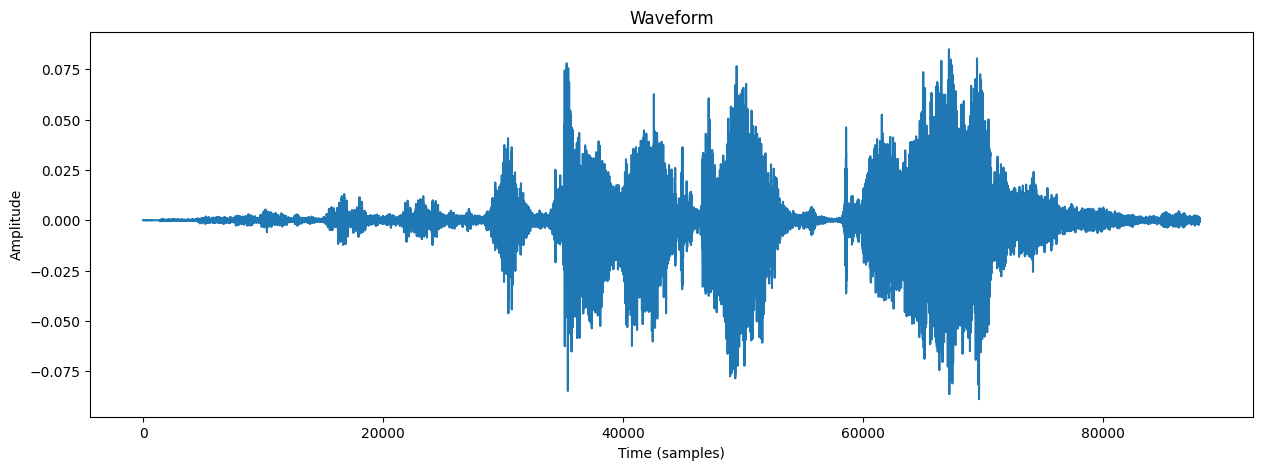

In [126]:
import matplotlib.pyplot as plt
import librosa

# Assuming you have already loaded the audio data and its sampling rate
data, sampling_rate = librosa.load("test_audio\\testing.wav")

plt.figure(figsize=(15, 5))
plt.plot(data)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()


In [127]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
opt = keras.optimizers.legacy.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


In [128]:
# Lets transform the dataset so we can apply the predictions
X, sample_rate = librosa.load('test_audio\\testing.wav'
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
newdf = pd.DataFrame(data=mfccs).T
newdf

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-30.026306,-29.706165,-30.909853,-30.25392,-31.256205,-34.220116,-34.363392,-34.823521,-36.290474,-37.629311,...,-17.246763,-17.477049,-18.214754,-18.126549,-18.393099,-17.516079,-18.313444,-22.279255,-17.918739,-13.256377


In [129]:
print(newdf.shape)
loaded_model.summary()

(1, 216)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_45 (Conv1D)          (None, 216, 128)          1152      
                                                                 
 activation_47 (Activation)  (None, 216, 128)          0         
                                                                 
 conv1d_46 (Conv1D)          (None, 216, 128)          131200    
                                                                 
 batch_normalization_16 (Ba  (None, 216, 128)          512       
 tchNormalization)                                               
                                                                 
 activation_48 (Activation)  (None, 216, 128)          0         
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 27, 128)           0         
 ng1D)                                       

In [130]:
import numpy as np


# Assuming newdf is your data
newdf = np.reshape(newdf, (1, 216, 1))  # Add the last dimension

newpred = loaded_model.predict(newdf, batch_size=16, verbose=1)


newpred


1/1 [==============================] - 1s 1s/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        5.5769318e-09, 5.4582054e-09, 4.8615611e-08, 2.6511585e-34,
        4.1062536e-28, 7.1738529e-17, 1.5389465e-32, 5.7976829e-29,
        2.8125727e-15, 0.0000000e+00]], dtype=float32)

In [131]:
filename = 'labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final) #emo(final) #gender(final) 

['female_happy']


In [133]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import pandas as pd
import librosa
import pickle
from tensorflow.keras.models import load_model
import sounddevice as sd
import soundfile as sf
import os

class EmotionDetectorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Emotion Detector")
        self.root.geometry("400x200")

        self.record_button = ttk.Button(root, text="Record Audio", command=self.record_audio)
        self.record_button.pack(pady=10)

        self.predict_button = ttk.Button(root, text="Predict Emotion", command=self.predict_emotion)
        self.predict_button.pack(pady=5)

        self.result_label = ttk.Label(root, text="")
        self.result_label.pack(pady=5)

        self.model = None
        self.label_encoder = None

    def record_audio(self):
        try:
            # Recording parameters
            duration = 5  # Recording duration in seconds
            fs = 44100   # Sampling frequency

            # Record audio
            recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype="float32")
            sd.wait()

            # Save recording to a WAV file
            audio_file = "recording.wav"
            sf.write(audio_file, recording, fs)

            messagebox.showinfo("Recording", "Audio recorded successfully!")

            # Pass the audio file path to the prediction function
            self.predict_emotion(audio_file)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to record audio: {e}")

    def predict_emotion(self, audio_file):
        try:
            # Code for loading model and label encoder if not already loaded
            if self.model is None:
                self.model = load_model("saved_models/Emotion_Model.h5")  # Load your model
            if self.label_encoder is None:
                self.label_encoder = pickle.load(open("labels", "rb"))  # Load label encoder

            # Code for processing audio and making predictions
            X, sample_rate = librosa.load(audio_file, res_type='kaiser_fast', duration=2.5, sr=44100, offset=0.5)
            sample_rate = np.array(sample_rate)
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
            newdf = pd.DataFrame(data=mfccs).T
            newdf = np.reshape(newdf, (1, 216, 1))  # Reshape for model input

            prediction = self.model.predict(newdf)
            predicted_label = self.label_encoder.inverse_transform(np.argmax(prediction))

            self.result_label.config(text=f"Predicted emotion: {predicted_label}")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to predict emotion: {e}")

if __name__ == "__main__":
    root = tk.Tk()
    app = EmotionDetectorApp(root)
    root.mainloop()


1/1 [==============================] - 1s 674ms/step
